In [109]:
using Distributions
using Roots
using StatsPlots
default(fmt=:png)

myecdf(A, x) = count(≤(x), A)/length(A)
safemul(x, y) = x == 0 ? zero(x*y) : y == 0 ? zero(x*y) : x*y
safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(x/y) : x/y

### score P-value for rate difference

riskdiffhat_score(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function loglik_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safemul(a, log(p)) + safemul(b, log(1-p)) + safemul(c, log(q)) + safemul(d, log(1-q))
end

function scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    Δ == 1 && return a-d + (-b+c)/q
    Δ == 1 && return a-d + (-b+c)/q
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p) + safediv(c, q) - safediv(d, 1-q)
end

function scorestat_Δ_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p)
end

function estimate_q_given_Δ_rd(a, b, c, d, Δ=0.0; alg=Bisection())
    qmin, qmax = max(0.0, -Δ), min(1.0, 1.0-Δ)
    a+c==0 && return qmin
    b+d==0 && return qmax
    f(q) = scorestat_q_rd(a, b, c, d, q, Δ)
    S_qmin = f(qmin + eps())
    S_qmax = f(qmax - eps())
    S_qmin ≥ 0 && S_qmax ≥ 0 && return S_qmin < S_qmax ? qmin : qmax
    S_qmin ≤ 0 && S_qmax ≤ 0 && return S_qmin < S_qmax ? qmax : qmin
    find_zero(f, (qmin + eps(), qmax - eps()), alg)
end

function varinv_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(p*(1-p), a+b) + safediv(q*(1-q), c+d)
end

function chisqstat_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    abs(Δ) == 1 && return Inf
    q̃ = estimate_q_given_Δ_rd(a, b, c, d, Δ; alg)
    S = scorestat_Δ_rd(a, b, c, d, q̃, Δ)
    Vinv = varinv_scorestat_q_rd(a, b, c, d, q̃, Δ)
    safemul(S^2, Vinv)
end

function pvalue_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    χ² = chisqstat_rd_score(a, b, c, d; Δ, alg)
    ccdf(Chisq(1), χ²)
end

function confint_rd_score(a, b, c, d; α=0.05, alg=Bisection())
    χ²_α = cquantile(Chisq(1), α)
    g(Δ) = chisqstat_rd_score(a, b, c, d; Δ, alg) - χ²_α
    Δ0 = riskdiffhat_score(a, b, c, d)
    L = if g(-1 + eps()) > 0
        find_zero(g, (-1 + eps(), Δ0), alg)
    else
        -1.0
    end
    U = if g(1 - eps()) > 0
        find_zero(g, (Δ0, 1 - eps()), alg)
    else
        1.0
    end
    [L, U]
end

confint_rd_score (generic function with 1 method)

In [110]:
a, b, c, d = 8, 0, 8, 0
@show Δ0 = riskdiffhat_score(a, b, c, d)
@show chisqstat_rd_score(a, b, c, d; Δ=Δ0)
chisqstat_rd_score(a, b, c, d; Δ=-0.9999)

Δ0 = riskdiffhat_score(a, b, c, d) = 0.0
chisqstat_rd_score(a, b, c, d; Δ = Δ0) = 0.0


79992.0000000088

In [111]:
a, b, c, d = 1, 2, 3, 4
pvalue_rd_score(1, 2, 3, 4), ccdf(Chisq(1), (a+b+c+d)*(a*d-b*c)^2/((a+b)*(c+d)*(a+c)*(b+d)))

(0.7781596861761658, 0.7781596861761658)

In [112]:
a, b, c, d = 3, 0, 4, 0
pvalue_rd_score(a, b, c, d), ccdf(Chisq(1), safediv((a+b+c+d)*(a*d-b*c)^2, (a+b)*(c+d)*(a+c)*(b+d)))

(1.0, 1.0)

riskdiffhat(a, b, c, d) = 0.10499999999999998
stderr_riskdiffhat(a, b, c, d) = 0.06962892717829279
pvalue_rd_wald(a, b, c, d) = 0.131556078861258
pvalue_rd_zou_donner(a, b, c, d) = 0.1366416912723798
pvalue_rd_score(a, b, c, d) = 0.13756389390990303
pvalue_rd_wald(a, b, c, d; Δ = 0.2) = 0.17244942526461607
pvalue_rd_zou_donner(a, b, c, d; Δ = 0.2) = 0.1691925373927276
pvalue_rd_score(a, b, c, d; Δ = 0.2) = 0.16421333544932085
confint_rd_wald(a, b, c, d; α = 0.05) = [-0.03147018955161626, 0.24147018955161623]
confint_rd_zou_donner(a, b, c, d; α = 0.05) = [-0.03337608563665168, 0.23942624927269288]
confint_rd_score(a, b, c, d; α = 0.05) = [-0.03406144531230887, 0.23764023265754816]


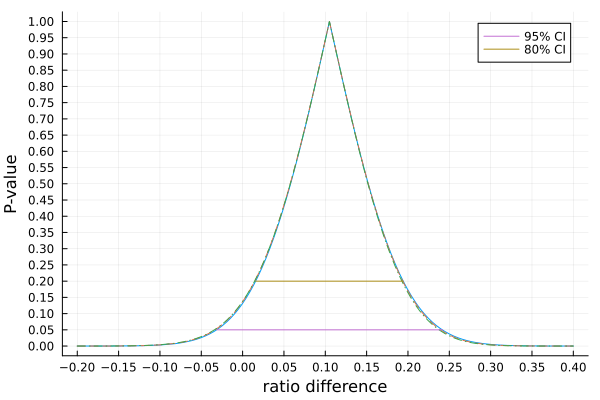

In [113]:
riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m) + safediv(q̂*(1-q̂), n))
end

function pvalue_rd_wald(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

riskdiffhat_zou_donner(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat_zou_donner(a, b, c, d; u=1)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-u) + safediv(q̂*(1-q̂), n-u))
end

function pvalue_rd_zou_donner(a, b, c, d; Δ=0, u=1)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    Z = safediv((1 - RDhat^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

function confint_rd_zou_donner(a, b, c, d; α=0.05, u=1)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    m = atanh(RDhat)
    d = safediv(z*SEhat_riskdiffhat, 1 - RDhat^2)
    [tanh(m-d), tanh(m+d)]
end

a, b = 58, 22
c, d = 62, 38

@show riskdiffhat(a, b, c, d)
@show stderr_riskdiffhat(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d)
@show pvalue_rd_zou_donner(a, b, c, d)
@show pvalue_rd_score(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d; Δ=0.2)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=0.2)
@show pvalue_rd_score(a, b, c, d; Δ=0.2)
@show confint_rd_wald(a, b, c, d; α=0.05)
@show confint_rd_zou_donner(a, b, c, d; α=0.05)
@show confint_rd_score(a, b, c, d; α=0.05)

plot(Δ -> pvalue_rd_wald(a, b, c, d; Δ), -0.2, 0.4; label="")
plot!(Δ -> pvalue_rd_zou_donner(a, b, c, d; Δ), -0.2, 0.4; label="", ls=:dash)
plot!(Δ -> pvalue_rd_score(a, b, c, d; Δ), -0.2, 0.4; label="", ls=:dashdot)
plot!(confint_rd_wald(a, b, c, d; α=0.05), fill(0.05, 2); label="95% CI")
plot!(confint_rd_wald(a, b, c, d; α=0.20), fill(0.20, 2); label="80% CI")
plot!(xguide="ratio difference", yguide="P-value")
plot!(xtick=-2:0.05:2, ytick=0:0.05:1)

riskdiffhat(a, b, c, d) = 0.5
stderr_riskdiffhat(a, b, c, d) = 0.19235384061671343
pvalue_rd_wald(a, b, c, d; Δ = -1.0) = 6.283192601804116e-15
pvalue_rd_zou_donner(a, b, c, d; Δ = -1.0) = 0.0
pvalue_rd_score(a, b, c, d; Δ = -1.0) = 0.0
pvalue_rd_wald(a, b, c, d) = 0.009339335240454794
pvalue_rd_zou_donner(a, b, c, d) = 0.04216672602077035
pvalue_rd_score(a, b, c, d) = 0.024618761380815177
pvalue_rd_wald(a, b, c, d; Δ = 0.2) = 0.11884835135568009
pvalue_rd_zou_donner(a, b, c, d; Δ = 0.2) = 0.19985393730515622
pvalue_rd_score(a, b, c, d; Δ = 0.2) = 0.16797021884889762
pvalue_rd_wald(a, b, c, d; Δ = 1.0) = 0.009339335240454794
pvalue_rd_zou_donner(a, b, c, d; Δ = 1.0) = 0.0
pvalue_rd_score(a, b, c, d; Δ = 1.0) = 0.0
confint_rd_wald(a, b, c, d; α = 0.05) = [0.12299340010328319, 0.8770065998967168]
confint_rd_zou_donner(a, b, c, d; α = 0.05) = [0.019437229905855672, 0.7928920704654783]
confint_rd_score(a, b, c, d; α = 0.05) = [0.0651491933146074, 0.7757547211173088]


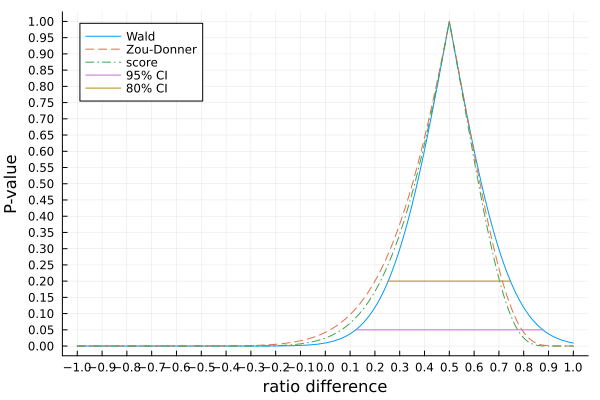

In [115]:
a, b = 8, 2
c, d = 3, 7

@show riskdiffhat(a, b, c, d)
@show stderr_riskdiffhat(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d; Δ=-1.0)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=-1.0)
@show pvalue_rd_score(a, b, c, d; Δ=-1.0)
@show pvalue_rd_wald(a, b, c, d)
@show pvalue_rd_zou_donner(a, b, c, d)
@show pvalue_rd_score(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d; Δ=0.2)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=0.2)
@show pvalue_rd_score(a, b, c, d; Δ=0.2)
@show pvalue_rd_wald(a, b, c, d; Δ=1.0)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=1.0)
@show pvalue_rd_score(a, b, c, d; Δ=1.0)
@show confint_rd_wald(a, b, c, d; α=0.05)
@show confint_rd_zou_donner(a, b, c, d; α=0.05)
@show confint_rd_score(a, b, c, d; α=0.05)

plot(Δ -> pvalue_rd_wald(a, b, c, d; Δ), -1, 1.0; label="Wald")
plot!(Δ -> pvalue_rd_zou_donner(a, b, c, d; Δ); label="Zou-Donner", ls=:dash)
plot!(Δ -> pvalue_rd_score(a, b, c, d; Δ); label="score", ls=:dashdot)
plot!(confint_rd_wald(a, b, c, d; α=0.05), fill(0.05, 2); label="95% CI")
plot!(confint_rd_wald(a, b, c, d; α=0.20), fill(0.20, 2); label="80% CI")
plot!(xguide="ratio difference", yguide="P-value")
plot!(xtick=-2:0.1:2, ytick=0:0.05:1)

riskdiffhat(a, b, c, d) = 0.04999999999999993
stderr_riskdiffhat(a, b, c, d) = 0.026220221204253793
pvalue_rd_wald(a, b, c, d; Δ = -1.0) = 0.0
pvalue_rd_zou_donner(a, b, c, d; Δ = -1.0) = 0.0
pvalue_rd_score(a, b, c, d; Δ = -1.0) = 0.0
pvalue_rd_wald(a, b, c, d) = 0.05653027716740456
pvalue_rd_zou_donner(a, b, c, d) = 0.05756709889261137
pvalue_rd_score(a, b, c, d) = 0.05765446863352155
pvalue_rd_wald(a, b, c, d; Δ = 0.2) = 1.0603891163569682e-8
pvalue_rd_zou_donner(a, b, c, d; Δ = 0.2) = 6.86064133615312e-9
pvalue_rd_score(a, b, c, d; Δ = 0.2) = 2.807958832237494e-6
pvalue_rd_wald(a, b, c, d; Δ = 1.0) = 1.938283089190621e-287
pvalue_rd_zou_donner(a, b, c, d; Δ = 1.0) = 0.0
pvalue_rd_score(a, b, c, d; Δ = 1.0) = 0.0
confint_rd_wald(a, b, c, d; α = 0.05) = [-0.0013906892270110355, 0.1013906892270109]
confint_rd_zou_donner(a, b, c, d; α = 0.05) = [-0.0016070410213381249, 0.10134141909439084]
confint_rd_score(a, b, c, d; α = 0.05) = [-0.0017086378965429085, 0.10514047710359503]


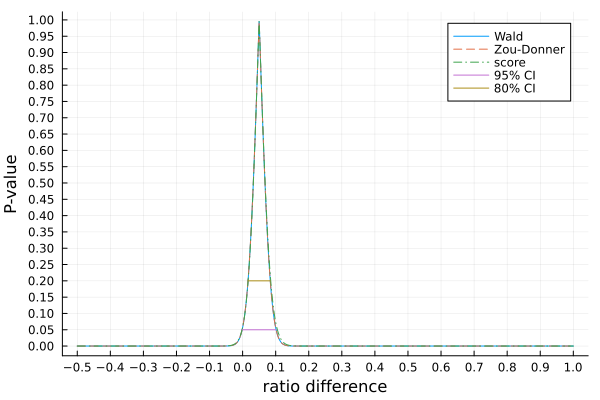

In [116]:
a, b = 190, 10
c, d = 180, 20

@show riskdiffhat(a, b, c, d)
@show stderr_riskdiffhat(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d; Δ=-1.0)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=-1.0)
@show pvalue_rd_score(a, b, c, d; Δ=-1.0)
@show pvalue_rd_wald(a, b, c, d)
@show pvalue_rd_zou_donner(a, b, c, d)
@show pvalue_rd_score(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d; Δ=0.2)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=0.2)
@show pvalue_rd_score(a, b, c, d; Δ=0.2)
@show pvalue_rd_wald(a, b, c, d; Δ=1.0)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=1.0)
@show pvalue_rd_score(a, b, c, d; Δ=1.0)
@show confint_rd_wald(a, b, c, d; α=0.05)
@show confint_rd_zou_donner(a, b, c, d; α=0.05)
@show confint_rd_score(a, b, c, d; α=0.05)

plot(Δ -> pvalue_rd_wald(a, b, c, d; Δ), -0.5, 1.0; label="Wald")
plot!(Δ -> pvalue_rd_zou_donner(a, b, c, d; Δ); label="Zou-Donner", ls=:dash)
plot!(Δ -> pvalue_rd_score(a, b, c, d; Δ); label="score", ls=:dashdot)
plot!(confint_rd_wald(a, b, c, d; α=0.05), fill(0.05, 2); label="95% CI")
plot!(confint_rd_wald(a, b, c, d; α=0.20), fill(0.20, 2); label="80% CI")
plot!(xguide="ratio difference", yguide="P-value")
plot!(xtick=-2:0.1:2, ytick=0:0.05:1)

riskdiffhat(a, b, c, d) = 0.0
stderr_riskdiffhat(a, b, c, d) = 0.0
pvalue_rd_wald(a, b, c, d; Δ = -1.0) = 0.0
pvalue_rd_zou_donner(a, b, c, d; Δ = -1.0) = 0.0
pvalue_rd_score(a, b, c, d; Δ = -1.0) = 0.0
pvalue_rd_wald(a, b, c, d) = 1.0
pvalue_rd_zou_donner(a, b, c, d) = 1.0
pvalue_rd_score(a, b, c, d) = 1.0
pvalue_rd_wald(a, b, c, d; Δ = 0.2) = 0.0
pvalue_rd_zou_donner(a, b, c, d; Δ = 0.2) = 0.0
pvalue_rd_score(a, b, c, d; Δ = 0.2) = 0.28612238439101817
pvalue_rd_wald(a, b, c, d; Δ = 1.0 - eps()) = 0.0
pvalue_rd_zou_donner(a, b, c, d; Δ = 1.0 - eps()) = 0.0
pvalue_rd_score(a, b, c, d; Δ = 1.0 - eps()) = 0.9999999682949161
pvalue_rd_wald(a, b, c, d; Δ = 1.0) = 0.0
pvalue_rd_zou_donner(a, b, c, d; Δ = 1.0) = 0.0
pvalue_rd_score(a, b, c, d; Δ = 1.0) = 0.0
confint_rd_wald(a, b, c, d; α = 0.05) = [0.0, 0.0]
confint_rd_zou_donner(a, b, c, d; α = 0.05) = [0.0, 0.0]
confint_rd_score(a, b, c, d; α = 0.05) = [-0.32440756488388034, 1.0]


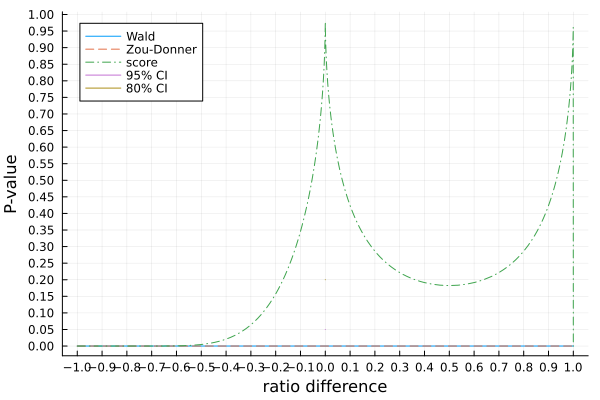

In [119]:
a, b = 8, 0
c, d = 9, 0

@show riskdiffhat(a, b, c, d)
@show stderr_riskdiffhat(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d; Δ=-1.0)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=-1.0)
@show pvalue_rd_score(a, b, c, d; Δ=-1.0)
@show pvalue_rd_wald(a, b, c, d)
@show pvalue_rd_zou_donner(a, b, c, d)
@show pvalue_rd_score(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d; Δ=0.2)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=0.2)
@show pvalue_rd_score(a, b, c, d; Δ=0.2)
@show pvalue_rd_wald(a, b, c, d; Δ=1.0-eps())
@show pvalue_rd_zou_donner(a, b, c, d; Δ=1.0-eps())
@show pvalue_rd_score(a, b, c, d; Δ=1.0-eps())
@show pvalue_rd_wald(a, b, c, d; Δ=1.0)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=1.0)
@show pvalue_rd_score(a, b, c, d; Δ=1.0)
@show confint_rd_wald(a, b, c, d; α=0.05)
@show confint_rd_zou_donner(a, b, c, d; α=0.05)
@show confint_rd_score(a, b, c, d; α=0.05)

plot(Δ -> pvalue_rd_wald(a, b, c, d; Δ), -1.0, 1.0; label="Wald")
plot!(Δ -> pvalue_rd_zou_donner(a, b, c, d; Δ); label="Zou-Donner", ls=:dash)
plot!(Δ -> pvalue_rd_score(a, b, c, d; Δ); label="score", ls=:dashdot)
plot!(confint_rd_wald(a, b, c, d; α=0.05), fill(0.05, 2); label="95% CI")
plot!(confint_rd_wald(a, b, c, d; α=0.20), fill(0.20, 2); label="80% CI")
plot!(xguide="ratio difference", yguide="P-value")
plot!(xtick=-2:0.1:2, ytick=0:0.05:1)

In [117]:
a, b = 190, 10
c, d = 180, 20
Δ = 0.5

@show estimate_q_given_Δ_rd(a, b, c, d, Δ)
@show scorestat_q_rd(a, b, c, d, 0.0, Δ)
@show scorestat_q_rd(a, b, c, d, 0.675, Δ)
@show scorestat_q_rd(a, b, c, d, 0.7, Δ)

find_zero(q -> (q; scorestat_q_rd(a, b, c, d, q, Δ)), (0.0, 1-Δ))

estimate_q_given_Δ_rd(a, b, c, d, Δ) = 0.4811054786311838
scorestat_q_rd(a, b, c, d, 0.0, Δ) = Inf
scorestat_q_rd(a, b, c, d, 0.675, Δ) = 423.9731899306367
scorestat_q_rd(a, b, c, d, 0.7, Δ) = 398.80952380952385


0.4811054786311838

scorestat_q_rd(a, b, c, d, 0.0, 0.3) = Inf
scorestat_q_rd(a, b, c, d, 0.0, 0.3) = Inf
S_qmin = scorestat_q_rd(a, b, c, d, qmin + eps(), Δ) = 9.457559217478043e17
S_qmax = scorestat_q_rd(a, b, c, d, qmax - eps(), Δ) = -9.45755921747804e17
q0 = (qmin + qmax) / 2 = 1.0
find_zero(f, q0, Order0()) = 1.0
find_zero(f, (qmin + eps(), qmax - eps())) = 1.0


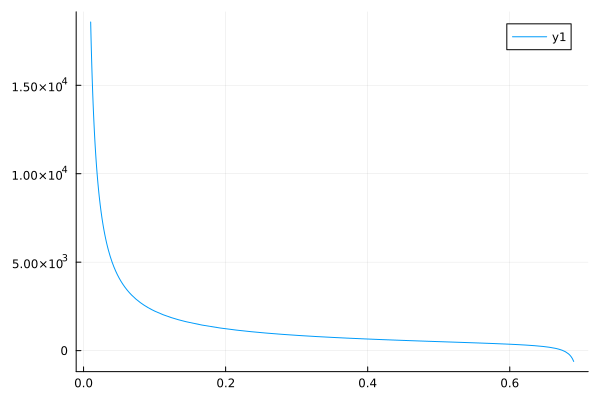

In [9]:
a, b = 190, 10
c, d = 180, 20
Δ = -1.0

@show scorestat_q_rd(a, b, c, d, 0.0, 0.3)
@show scorestat_q_rd(a, b, c, d, 0.0, 0.3)

qmin, qmax = max(0.0, -Δ), min(1.0, 1.0-Δ)
a+c==0 && @show qmin
b+d==0 && @show qmax
@show S_qmin = scorestat_q_rd(a, b, c, d, qmin+eps(), Δ)
@show S_qmax = scorestat_q_rd(a, b, c, d, qmax-eps(), Δ)
S_qmin ≥ 0 && S_qmax ≥ 0 && @show S_qmin < S_qmax ? qmin : qmax
S_qmin ≤ 0 && S_qmax ≤ 0 && @show S_qmin < S_qmax ? qmax : qmin
f(q) = scorestat_q_rd(a, b, c, d, q, Δ)
@show q0 = (qmin + qmax)/2
@show find_zero(f, q0, Order0())
@show find_zero(f, (qmin+eps(), qmax-eps()))


plot(q -> scorestat_q_rd(a, b, c, d, q, 0.3), 0.01, 0.69)

scorestat_q_rd(a, b, c, d, 0.0, 0.3) = Inf
scorestat_q_rd(a, b, c, d, 0.7, 0.3) = 38.57142857142857


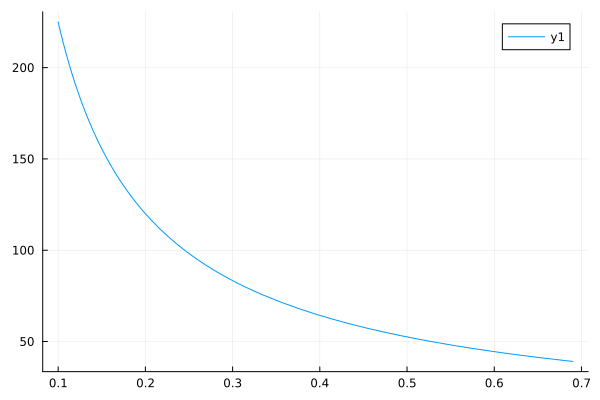

In [10]:
a, b = 10, 0
c, d = 20, 0

@show scorestat_q_rd(a, b, c, d, 0.0, 0.3)
@show scorestat_q_rd(a, b, c, d, 0.7, 0.3)

plot(q -> scorestat_q_rd(a, b, c, d, q, 0.3), 0.1, 0.69)

riskdiffhat(a, b, c, d) = 0.0
stderr_riskdiffhat(a, b, c, d) = 0.0
pvalue_rd_wald(a, b, c, d) = 1.0
pvalue_rd_zou_donner(a, b, c, d) = 1.0
pvalue_rd_score(a, b, c, d) = 1.0
pvalue_rd_wald(a, b, c, d; Δ = 0.2) = 0.0
pvalue_rd_zou_donner(a, b, c, d; Δ = 0.2) = 0.0
pvalue_rd_score(a, b, c, d; Δ = 0.2) = 0.4795001221869535


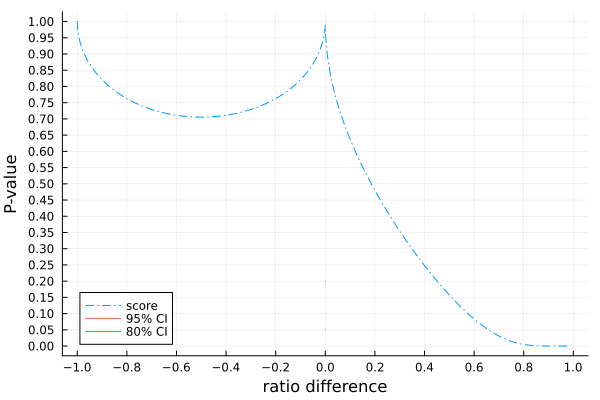

In [11]:
a, b = 0, 2
c, d = 0, 7

@show riskdiffhat(a, b, c, d)
@show stderr_riskdiffhat(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d)
@show pvalue_rd_zou_donner(a, b, c, d)
@show pvalue_rd_score(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d; Δ=0.2)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=0.2)
@show pvalue_rd_score(a, b, c, d; Δ=0.2)

plot(Δ -> pvalue_rd_score(a, b, c, d; Δ), -1, 1; label="score", ls=:dashdot)
plot!(confint_rd_wald(a, b, c, d; α=0.05), fill(0.05, 2); label="95% CI")
plot!(confint_rd_wald(a, b, c, d; α=0.20), fill(0.20, 2); label="80% CI")
plot!(xguide="ratio difference", yguide="P-value")
plot!(xtick=-1:0.2:1, ytick=0:0.05:1)

riskdiffhat(a, b, c, d) = 0.09090909090909094
stderr_riskdiffhat(a, b, c, d) = 0.08667841720414476
pvalue_rd_wald(a, b, c, d) = 0.2942661043049627
pvalue_rd_zou_donner(a, b, c, d) = 0.31998864444855146
pvalue_rd_score(a, b, c, d) = 0.5325042685883555
pvalue_rd_wald(a, b, c, d; Δ = 0.2) = 0.2081854653425478
pvalue_rd_zou_donner(a, b, c, d; Δ = 0.2) = 0.22354842669793862
pvalue_rd_score(a, b, c, d; Δ = 0.2) = 0.6295089293125519
pvalue_rd_wald(a, b, c, d; Δ = -1.0) = 2.5306945544231005e-36
pvalue_rd_zou_donner(a, b, c, d; Δ = -1.0) = 0.0
pvalue_rd_score(a, b, c, d; Δ = -1.0 + √(eps())) = 0.0
pvalue_rd_wald(a, b, c, d; Δ = 1.0) = 9.79907384197949e-26
pvalue_rd_zou_donner(a, b, c, d; Δ = 1.0) = 0.0
pvalue_rd_score(a, b, c, d; Δ = 1.0) = 1.0


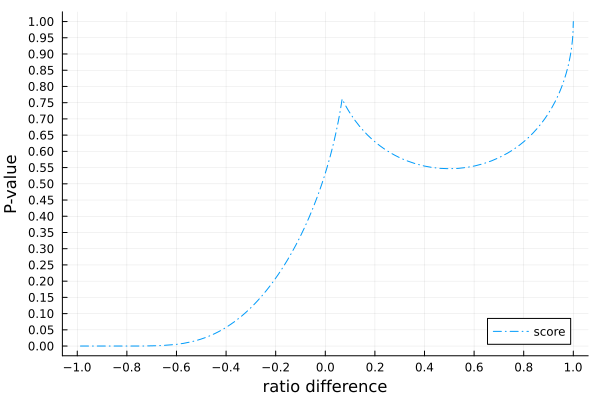

In [12]:
a, b = 4, 0
c, d = 10, 1

@show riskdiffhat(a, b, c, d)
@show stderr_riskdiffhat(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d)
@show pvalue_rd_zou_donner(a, b, c, d)
@show pvalue_rd_score(a, b, c, d)
@show pvalue_rd_wald(a, b, c, d; Δ=0.2)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=0.2)
@show pvalue_rd_score(a, b, c, d; Δ=0.2)
@show pvalue_rd_wald(a, b, c, d; Δ=-1.0)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=-1.0)
@show pvalue_rd_score(a, b, c, d; Δ=-1.0+√eps())
@show pvalue_rd_wald(a, b, c, d; Δ=1.0)
@show pvalue_rd_zou_donner(a, b, c, d; Δ=1.0)
@show pvalue_rd_score(a, b, c, d; Δ=1.0)

plot(Δ -> pvalue_rd_score(a, b, c, d; Δ), -1, 1; label="score", ls=:dashdot)
plot!(xguide="ratio difference", yguide="P-value")
plot!(xtick=-1:0.2:1, ytick=0:0.05:1)

scorestat_q_rd(a, b, c, d, 0.0, 0.2) = Inf
scorestat_q_rd(a, b, c, d, 0.8, 0.2) = 13.0


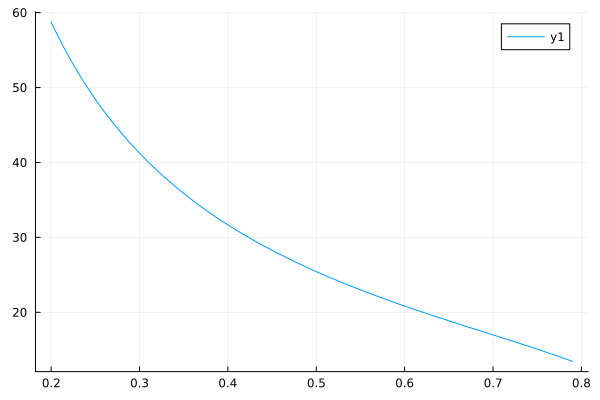

In [13]:
a, b = 8, 0
c, d = 8, 1

@show scorestat_q_rd(a, b, c, d, 0.0, 0.2)
@show scorestat_q_rd(a, b, c, d, 0.8, 0.2)

plot(q -> scorestat_q_rd(a, b, c, d, q, 0.2), 0.2, 0.79)

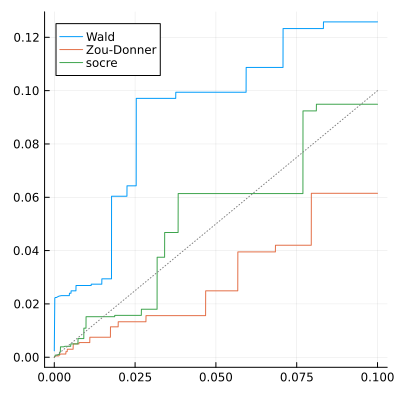

In [14]:
m = n = 10
L = 10^4
a = rand(Binomial(m, 0.8), L)
b = m .- a
c = rand(Binomial(n, 0.3), L)
d = n .- c
pval_wald = pvalue_rd_wald.(a, b, c, d; Δ=0.5)
pval_zd = pvalue_rd_zou_donner.(a, b, c, d; Δ=0.5)
pval_score = pvalue_rd_score.(a, b, c, d; Δ=0.5)

plot(α -> myecdf(pval_wald, α), 0, 0.1; label="Wald")
plot!(α -> myecdf(pval_zd, α); label="Zou-Donner")
plot!(α -> myecdf(pval_score, α); label="socre")
plot!(identity; label="", c=:gray, ls=:dot)
plot!(size=(400, 400))

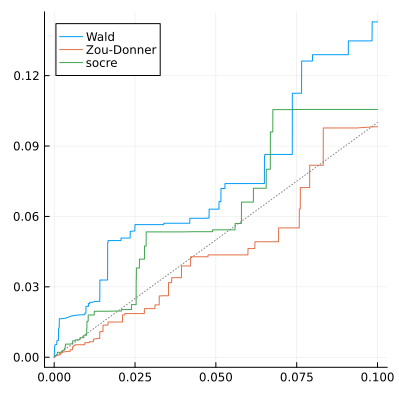

In [15]:
m, n = 20, 20
L = 10^4
a = rand(Binomial(m, 0.8), L)
b = m .- a
c = rand(Binomial(n, 0.3), L)
d = n .- c
pval_wald = pvalue_rd_wald.(a, b, c, d; Δ=0.5)
pval_zd = pvalue_rd_zou_donner.(a, b, c, d; Δ=0.5)
pval_score = pvalue_rd_score.(a, b, c, d; Δ=0.5)

plot(α -> myecdf(pval_wald, α), 0, 0.1; label="Wald")
plot!(α -> myecdf(pval_zd, α); label="Zou-Donner")
plot!(α -> myecdf(pval_score, α); label="socre")
plot!(identity; label="", c=:gray, ls=:dot)
plot!(size=(400, 400))

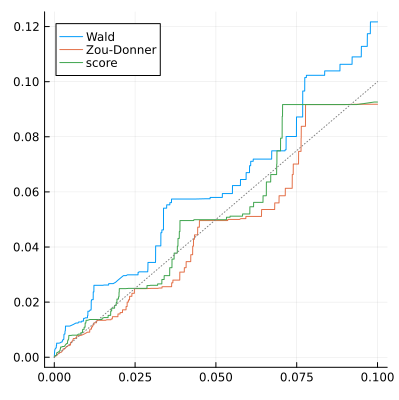

In [16]:
m, n = 40, 40
L = 10^4
a = rand(Binomial(m, 0.8), L)
b = m .- a
c = rand(Binomial(n, 0.3), L)
d = n .- c
pval_wald = pvalue_rd_wald.(a, b, c, d; Δ=0.5)
pval_zd = pvalue_rd_zou_donner.(a, b, c, d; Δ=0.5)
pval_score = pvalue_rd_score.(a, b, c, d; Δ=0.5)

plot(α -> myecdf(pval_wald, α), 0, 0.1; label="Wald")
plot!(α -> myecdf(pval_zd, α); label="Zou-Donner")
plot!(α -> myecdf(pval_score, α); label="score")
plot!(identity; label="", c=:gray, ls=:dot)
plot!(size=(400, 400))

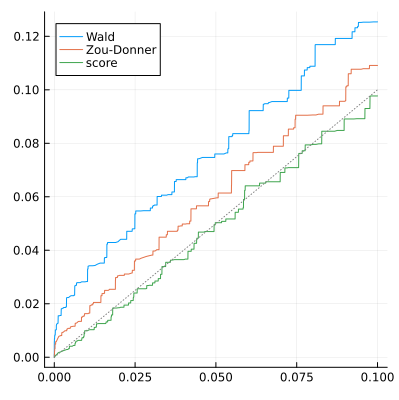

In [17]:
m, n = 20, 100
L = 10^4
a = rand(Binomial(m, 0.8), L)
b = m .- a
c = rand(Binomial(n, 0.3), L)
d = n .- c
pval_wald = pvalue_rd_wald.(a, b, c, d; Δ=0.5)
pval_zd = pvalue_rd_zou_donner.(a, b, c, d; Δ=0.5)
pval_score = pvalue_rd_score.(a, b, c, d; Δ=0.5)

plot(α -> myecdf(pval_wald, α), 0, 0.1; label="Wald")
plot!(α -> myecdf(pval_zd, α); label="Zou-Donner")
plot!(α -> myecdf(pval_score, α); label="score")
plot!(identity; label="", c=:gray, ls=:dot)
plot!(size=(400, 400))

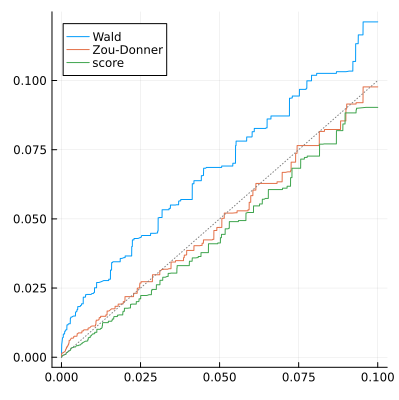

In [18]:
m, n = 100, 20
L = 10^4
a = rand(Binomial(m, 0.8), L)
b = m .- a
c = rand(Binomial(n, 0.3), L)
d = n .- c
pval_wald = pvalue_rd_wald.(a, b, c, d; Δ=0.5)
pval_zd = pvalue_rd_zou_donner.(a, b, c, d; Δ=0.5)
pval_score = pvalue_rd_score.(a, b, c, d; Δ=0.5)

plot(α -> myecdf(pval_wald, α), 0, 0.1; label="Wald")
plot!(α -> myecdf(pval_zd, α); label="Zou-Donner")
plot!(α -> myecdf(pval_score, α); label="score")
plot!(identity; label="", c=:gray, ls=:dot)
plot!(size=(400, 400))

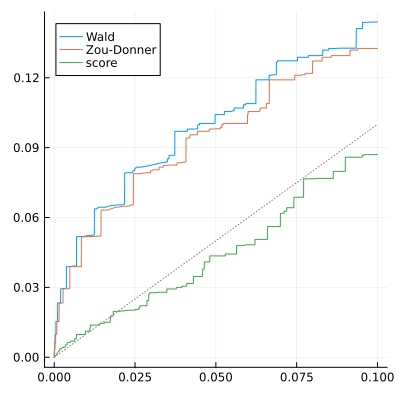

In [19]:
m, n = 20, 100
p, q = 0.1, 0.2
Δ = p - q
L = 10^4
a = rand(Binomial(m, p), L)
b = m .- a
c = rand(Binomial(n, q), L)
d = n .- c
pval_wald = pvalue_rd_wald.(a, b, c, d; Δ)
pval_zd = pvalue_rd_zou_donner.(a, b, c, d; Δ)
pval_score = pvalue_rd_score.(a, b, c, d; Δ)

plot(α -> myecdf(pval_wald, α), 0, 0.1; label="Wald")
plot!(α -> myecdf(pval_zd, α); label="Zou-Donner")
plot!(α -> myecdf(pval_score, α); label="score")
plot!(identity; label="", c=:gray, ls=:dot)
plot!(size=(400, 400))

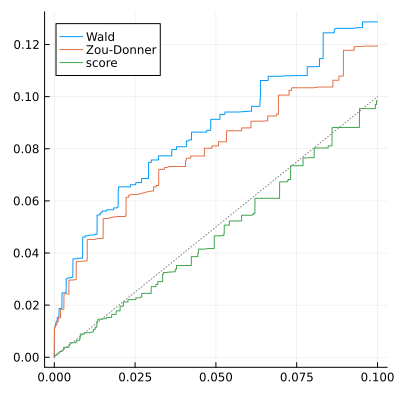

In [20]:
m, n = 100, 20
p, q = 0.1, 0.2
Δ = p - q
L = 10^4
a = rand(Binomial(m, p), L)
b = m .- a
c = rand(Binomial(n, q), L)
d = n .- c
pval_wald = pvalue_rd_wald.(a, b, c, d; Δ)
pval_zd = pvalue_rd_zou_donner.(a, b, c, d; Δ)
pval_score = pvalue_rd_score.(a, b, c, d; Δ)

plot(α -> myecdf(pval_wald, α), 0, 0.1; label="Wald")
plot!(α -> myecdf(pval_zd, α); label="Zou-Donner")
plot!(α -> myecdf(pval_score, α); label="score")
plot!(identity; label="", c=:gray, ls=:dot)
plot!(size=(400, 400))

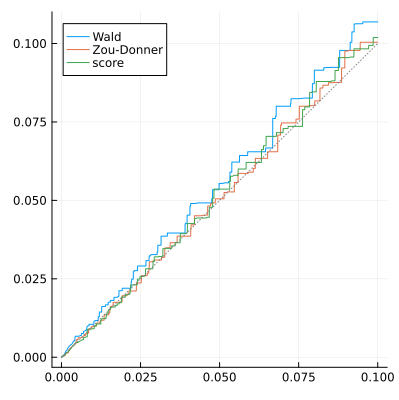

In [21]:
m, n = 60, 60
p, q = 0.1, 0.2
Δ = p - q
L = 10^4
a = rand(Binomial(m, p), L)
b = m .- a
c = rand(Binomial(n, q), L)
d = n .- c
pval_wald = pvalue_rd_wald.(a, b, c, d; Δ)
pval_zd = pvalue_rd_zou_donner.(a, b, c, d; Δ)
pval_score = pvalue_rd_score.(a, b, c, d; Δ)

plot(α -> myecdf(pval_wald, α), 0, 0.1; label="Wald")
plot!(α -> myecdf(pval_zd, α); label="Zou-Donner")
plot!(α -> myecdf(pval_score, α); label="score")
plot!(identity; label="", c=:gray, ls=:dot)
plot!(size=(400, 400))

In [48]:
function polynom_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    a*(1-p)*q*(1-q) - b*p*q*(1-q) + c*p*(1-p)*(1-q) - d*p*(1-p)*q
end

polynom_scorestat_q_rd (generic function with 2 methods)

Δ = 0.2 = 0.2
riskdiffhat_score(a, b, c, d) = 0.0


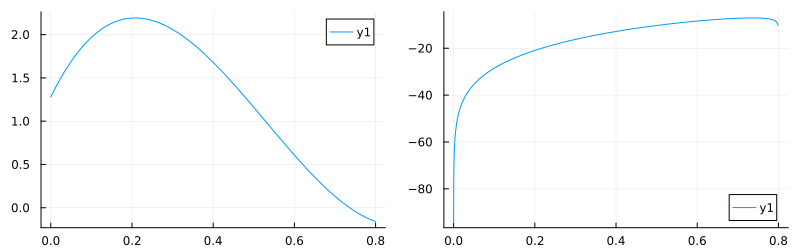

In [80]:
a, b, c, d = 8, 1, 8, 1
@show Δ = 0.2
@show riskdiffhat_score(a, b, c, d)
P = plot(q -> polynom_scorestat_q_rd(a, b, c, d, q, Δ), 0, 1-Δ)
Q = plot(q -> loglik_rd(a, b, c, d, q, Δ), 0, 1-Δ)
plot(P, Q; layout=(1, 2), size=(800, 250))

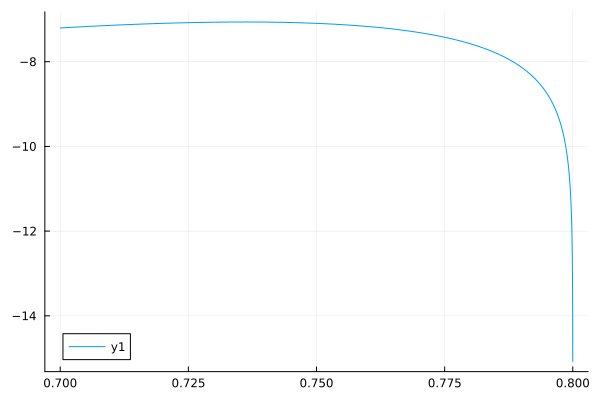

In [82]:
plot(q -> loglik_rd(a, b, c, d, q, Δ), 1-Δ-0.1, 1-Δ)